# Sjoin + overlay 

`overlay` is taking a long time, but since there's a dissolve, it's basically 1 row for T-Mobile compared to 1 row for the district boundary. Might be able to treat them as GeoSeries and see if it can go through faster.

`difference` can also take multiple rows for T-Mobile compared to 1 row for district boundary. In this case, the dissolve for where there's no coverage for T-Mobile should take place after the difference is taken.

* `difference`: https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.difference.html


In [70]:
import dask.dataframe as dd
import dask_geopandas as dg
import geopandas as gpd
import pandas as pd
from shared_utils import geography_utils
from shared_utils import utils

from calitp.sql import to_snakecase
import A1_provider_prep
import A2_analysis
import A3_other

In [71]:
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

In [72]:
# Original map - includes other stuff that isn't California
# tmobile = dg.read_parquet(
   # "gs://calitp-analytics-data/data-analyses/cellular_coverage/tmobile_california.parquet"
# )

###  Notes
* Utilities.complete_difference_provider_district_level() stops at D6 for Verizon

In [73]:
verizon = dg.read_parquet("Verizon.parquet")

In [74]:
# v_complete = utilities.complete_difference_provider_district_level(verizon, districts, "verizon")

### Debug D4
* Lots of D4 routes popping up as 100% intersecting with no coverage ares.

In [75]:
# Original AT&T map that is ONLY clipped to California
att = dg.read_parquet("ATT.parquet")

In [76]:
att_gdf = att.compute()

<AxesSubplot:>

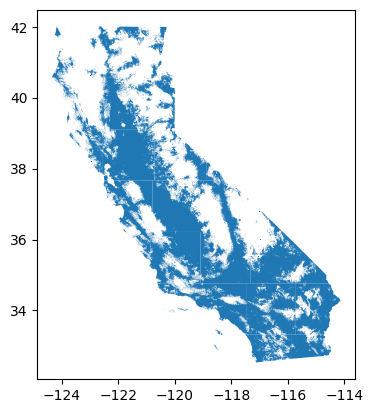

In [77]:
att_gdf.plot()

In [78]:
districts = A1_provider_prep.get_districts()

In [79]:
# Subset to D4
d4 =  districts[districts.district == 4]

<AxesSubplot:>

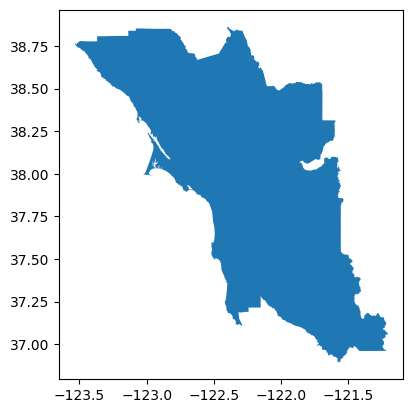

In [80]:
# Og d4 shape
d4.plot()

In [81]:
# Clip original AT&T map against D4
clipped_d4_att = dg.clip(att, d4)

In [82]:
clipped_d4_att.columns

Index(['geometry'], dtype='object')

In [83]:
clipped_d4_att_gdf = clipped_d4_att.compute()

<AxesSubplot:>

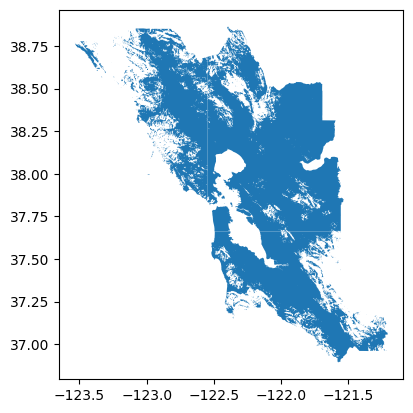

In [84]:
clipped_d4_att_gdf.plot()

In [85]:
# Finding no coverage areas 
att_d4_no_coverage = A1_provider_prep.find_difference_and_clip(att, d4)

<AxesSubplot:>

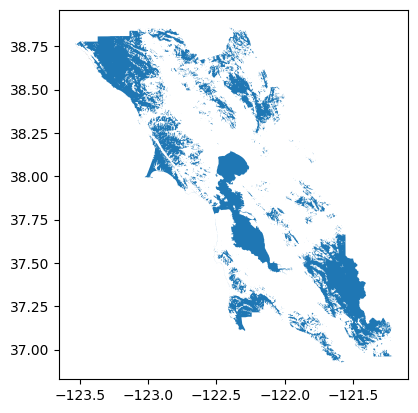

In [86]:
att_d4_no_coverage.plot()

In [87]:
# Finding no coverage areas using iloc_find_difference_district
att_d4_iloc = A1_provider_prep.iloc_find_difference_district(att, d4, 'att')

saved att_d4 parquet
att_no_coverage_d4 parquet


<AxesSubplot:>

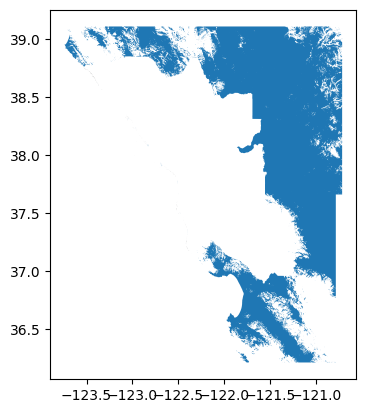

In [88]:
att_d4_iloc.plot()

In [89]:
# sjoin original AT&T map against D4
sjoin_d4_att_intersects = dg.sjoin(
        att, 
        d4, 
        how="inner", 
        predicate = "intersects"
    ).drop(columns = "index_right")

In [90]:
sjoin_d4_att_gdf = sjoin_d4_att.compute()

In [91]:
type(sjoin_d4_att_gdf)

geopandas.geodataframe.GeoDataFrame

<AxesSubplot:>

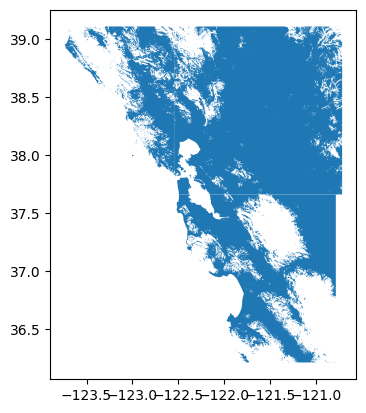

In [92]:
sjoin_d4_att_gdf.plot()

In [126]:
sjoin_d4_att_intersects_difference = sjoin_d4_att_intersects.difference(
        d4.geometry.iloc[0], 
    ).reset_index()

In [128]:
sjoin_d4_att_intersects_difference_gdf = sjoin_d4_att_intersects_difference.compute()

<AxesSubplot:>

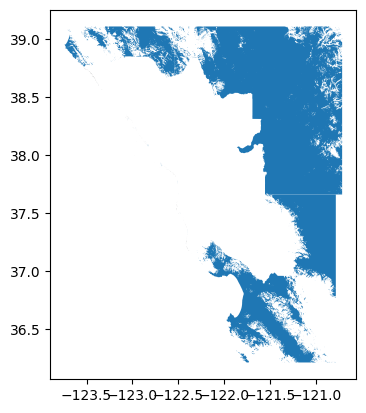

In [130]:
sjoin_d4_att_intersects_difference_gdf.plot()

In [93]:
# sjoin original AT&T map against D4
sjoin_d4_att_within = dg.sjoin(
        d4, 
        att, 
        how="inner", 
        predicate = "within"
    ).drop(columns = "index_right")

In [94]:
sjoin_d4_att_within = sjoin_d4_att_within.compute()

In [95]:
sjoin_d4_att_within.shape

(0, 2)

In [96]:
# Load in the version I created using function "complete_difference_provider_district_level"
# att_function = dg.read_parquet(f"{A1_provider_prep.GCS_FILE_PATH}att_all_counties.parquet")

In [97]:
unique_routes = A3_other.load_unique_routes_df()

In [98]:
d4_routes = A2_analysis.comparison(att_d4_iloc, unique_routes)

In [99]:
d4_routes2 = A2_analysis.dissolve_summarize(d4_routes)

In [100]:
d4_routes2[['agency','long_route_name','percentage_route_covered']].sort_values('agency')

,agency,long_route_name,percentage_route_covered
0,Amador Regional Transit System,Ione 661 Amador Regional Transit System,97
1,Amador Regional Transit System,Plymouth 571 Amador Regional Transit System,82
2,Amador Regional Transit System,Sacramento 569 Amador Regional Transit System,98
3,Amador Regional Transit System,Sutter Creek-Jackson Shuttle 573 Amador Regional Transit System,80
4,Amador Regional Transit System,Sutter Creek-Jackson Shuttle 660 Amador Regional Transit System,79
5,Amador Regional Transit System,Upcountry 570 Amador Regional Transit System,25
6,Auburn Transit,Auburn Loop 32372 Auburn Transit,99
7,Calaveras Transit,Red Line 556 Calaveras Transit,19
8,Capitol Corridor,Shuttle to Auburn s Capitol Corridor,97
9,Capitol Corridor,Shuttle to Auburn shuttle Capitol Corridor,97


### iloc function county

In [101]:
def find_difference_county(
    provider_df: dg.GeoDataFrame, 
    county_df: gpd.GeoDataFrame,
) -> dg.GeoDataFrame:
    
    # Clip provider to CT district
    provider_county = dg.sjoin(
        provider_df, 
        county_df, 
        how="inner", 
        predicate="intersects"
    ).drop(columns = "index_right")
    
    # Compute back to normal gdf
    provider_county = provider_county.compute()
    
    # Get areas without coverage
    no_coverage = provider_county.difference(
        county_df.geometry.iloc[0], 
    ).reset_index()
    
    # Turn to gdf
    no_coverage = (no_coverage.reset_index()
                  .dissolve()
                  .rename(columns = {0: 'geometry'})
                  [["geometry"]]
                 )
    # Set geometry
    no_coverage = no_coverage.set_geometry('geometry')
    
    return no_coverage

In [102]:
counties.plot()

NameError: name 'counties' is not defined

In [ ]:
kern.plot()

In [ ]:
counties.geometry.is_valid.all()

In [ ]:
verizon = utilities.load_verizon()

In [ ]:
kern_v = find_difference_county(verizon, kern)

In [ ]:
county_list = counties.county_name.sort_values().unique().tolist()

In [ ]:
def complete_difference_provider_county_level(
    provider_df: dg.GeoDataFrame, 
    county_df: gpd.GeoDataFrame,
    provider_name: str,) -> dg.GeoDataFrame:
    full_gdf = pd.DataFrame()
    
    county_list = county_df.county_name.sort_values().unique().tolist()
    
    for i in county_list:
        result = find_difference_county(
            provider_df, 
            county_df[county_df.county_name==i]
        )

        full_gdf = dd.multi.concat([full_gdf, result], axis=0)
        print(f"done for {i}")
    full_gdf = full_gdf.compute()
    
    utils.geoparquet_gcs_export(full_gdf, utilities.GCS_FILE_PATH, f"{provider_name}_no_coverage_complete_CA")
    return full_gdf

In [ ]:
# test = complete_difference_provider_county_level(verizon, counties, 'verizon',)

In [ ]:
test_ver.plot()

#### iloc testing

In [ ]:
# For files that are split apart by counties/districts
# That needs to be combined together to create a full California map
# https://www.geeksforgeeks.org/how-to-read-multiple-data-files-into-pandas/
def concat_all_areas(file_list:list, provider_name:str):
    main_dataframe = pd.DataFrame(gpd.read_parquet(file_list[0]))
    for i in range(1,len(file_list)):
        data = pd.gpd.read_parquet(file_list[i])
        df = pd.DataFrame(data)
        full_dataframe = dd.multi.concat([full_dataframe,df],axis=1)
        
    full_dataframe = full_dataframe.compute()
    
    utils.geoparquet_gcs_export(full_gdf, utilities.GCS_FILE_PATH, f"{provider_name}_no_coverage_complete_CA")
    return full_dataframe

In [ ]:
test_tmobile.plot()

In [ ]:
# Blue parts are areas with coverage in D5. 
"""
tmobile_district = dg.sjoin(
    tmobile[["geometry"]], 
    ct_all_districts[ct_all_districts.district==5],
    how="inner", 
    predicate="intersects"
).drop(columns = "index_right")"""

In [ ]:
tmobile_d5 = tmobile_district.compute()

In [ ]:
len(tmobile_d5)

In [ ]:
tmobile_d5.head(1)

In [ ]:
type(tmobile_d5)

In [ ]:
# Getting areas without coverage in D2. 
#no_coverage = tmobile_d5.difference(
  #      ct_all_districts[ct_all_districts.district==5].geometry.iloc[0], 
   # ).reset_index()

In [ ]:
# This line grabs the actual polygon 
# ct_all_districts[ct_all_districts.district==2].geometry.iloc[0]

In [ ]:
no_coverage_d5 = (no_coverage.reset_index()
                  .dissolve()
                  .rename(columns = {0: 'geometry'})
                  [["geometry"]]
                 )

In [ ]:
no_coverage_d5 = no_coverage_d5.set_geometry('geometry')

In [ ]:
type(no_coverage_d5), no_coverage_d5.columns

In [ ]:
utils.geoparquet_gcs_export(no_coverage_d5, utilities.GCS_FILE_PATH, f"test_d5")

In [ ]:
test_d5 = gpd.read_parquet(
    "gs://calitp-analytics-data/data-analyses/cellular_coverage/test_d5.parquet"
)

In [ ]:
type(test_d5)

In [ ]:
test_d5.plot()

#### Break apart dissolve

In [ ]:
ct_d5  = (ct_all_districts[ct_all_districts.district==5]

In [ ]:
ct_d5

In [ ]:
ct_all_districts[ct_all_districts.district==5]

In [ ]:
ct_d5.plot()

In [ ]:
tmobile_district = dg.sjoin(
        tmobile[['geometry']], 
        ct_d5, 
        how="inner", 
        predicate="intersects"
    )

In [ ]:
tmobile_district_gdf = tmobile_district.compute()

In [ ]:
len(tmobile_district_gdf)

In [ ]:
tmobile_district_gdf.head(1)

In [ ]:
"""
tmobile_5 = (tmobile_district.drop(columns = "index_right").dissolve(by="district")
                    .reset_index()
                    .compute()
                   )"""

In [ ]:
len(tmobile_5)

In [ ]:
district_file = tmobile_5.district.iloc[0]

In [ ]:
district_file

In [ ]:
tmobile_5

In [ ]:
# utils.geoparquet_gcs_export(tmobile_5, utilities.GCS_FILE_PATH,f"tmobile_d{district_file}.parquet")

In [ ]:
tmobile_align_true = (tmobile_5.difference(
            (ct_all_districts[ct_all_districts.district==5]).reset_index(), 
            align=True
        ).reset_index()
        .rename(columns = {0: 'geometry'})
    )   

In [ ]:
type(tmobile_align_true)

In [ ]:
tmobile_align_true = tmobile_align_true.set_geometry('geometry')

In [ ]:
# I get an error when plotting /opt/conda/lib/python3.9/site-packages/geopandas/array.py:938: RuntimeWarning: All-NaN slice encountered
tmobile_align_true.plot()

In [ ]:
def sjoin_to_district_find_difference(
    tmobile: dg.GeoDataFrame, 
    district_df: gpd.GeoDataFrame
) -> dg.GeoDataFrame:
    tmobile_district = dg.sjoin(
        tmobile, 
        district_df, 
        how="inner", 
        predicate="intersects"
    ).drop(columns = "index_right")
    
    # Dissolve so that it's just 1 row for TMobile coverage in that district
    tmobile_diss = (tmobile_district.dissolve(by="district")
                    .reset_index()
                    .compute()
                   )
    
    # Maybe stash intermediate output here?
    d = district_df.district.iloc[0]
    tmobile_diss.to_parquet(f"tmobile_d{d}.parquet")
    
    # Instead of gpd.overlay(), since tmobile_diss is 1 row and 
    # district_df is 1 row,
    # can treat them as GeoSeries, align=True, to do row-wise comparison
    no_coverage = (tmobile_diss.difference(
            ct_all_districts[ct_all_districts.district==i], 
            align=True
        ).reset_index()
        .rename(columns = {0: 'geometry'})
    )   
    
    no_coverage.to_parquet(f"no_coverage_d{d}.parquet")
    
    return no_coverage

In [ ]:
results = []

for i in [1]:
    dissolved_result = sjoin_to_district_find_difference(
        tmobile[["geometry"]], 
        ct_all_districts[ct_all_districts.district==i]
    )
    
    results.append(dissolved_result)

In [ ]:
ddf = dd.multi.concat(results, axis=0)

In [ ]:
df = ddf.compute()